In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isdir(path):
            images.extend(load_images_from_folder(path))
        else:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

In [ ]:
def normalize_images(images):
    normalized_images = []
    for img in images:
        resized_img = cv2.resize(img, (100, 100))  # Resize the image to 100x100
        normalized_img = resized_img.flatten() / 255.0  # Normalize pixel values to the range of 0-1
        normalized_images.append(normalized_img)
    return normalized_images

In [ ]:
def calculate_mean(images):
    mean_image = np.mean(images, axis=0)
    return mean_image

In [ ]:
def subtract_mean(images, mean_image):
    subtracted_images = []
    for img in images:
        subtracted_img = img - mean_image
        subtracted_images.append(subtracted_img)
    return subtracted_images

In [ ]:
def calculate_covariance_matrix(images):
    X = np.array(images)
    covariance_matrix = np.cov(X.T)
    return covariance_matrix

In [ ]:
def calculate_eigenfaces(covariance_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    idx = np.argsort(eigenvalues)[::-1]  # Sort eigenvalues in descending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

In [ ]:
def reduce_dimension(images, eigenvectors, num_components):
    reduced_images = []
    for img in images:
        reduced_img = np.dot(eigenvectors[:, :num_components].T, img)
        reduced_images.append(reduced_img)
    return reduced_images

In [ ]:
dataset_folder = '/content/drive/My Drive/TugasAkhir/datasetwajah/dataset'
model_path = '/content/drive/My Drive/TugasAkhir/datasetwajah/model.pkl'

In [ ]:
# Load model dari file jika sudah ada
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
else:
    images = load_images_from_folder(dataset_folder)
    normalized_images = normalize_images(images)

    mean_image = calculate_mean(normalized_images)
    subtracted_images = subtract_mean(normalized_images, mean_image)

    covariance_matrix = calculate_covariance_matrix(subtracted_images)

    eigenvalues, eigenvectors = calculate_eigenfaces(covariance_matrix)

    num_components = 10
    reduced_images = reduce_dimension(subtracted_images, eigenvectors, num_components)

    labels = []  # List of class labels for each face image
    for root, dirs, files in os.walk(dataset_folder):
        if len(files) > 0:
            label = root.split('/')[-1]  # Extract the class label from the folder path
            labels.extend([label] * len(files))

    X_train = np.array(reduced_images)
    y_train = np.array(labels)

    # Simpan model ke file
    model = {
        'mean_image': mean_image,
        'eigenvectors': eigenvectors,
        'num_components': num_components,
        'X_train': X_train,
        'y_train': y_train
    }
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

mean_image = model['mean_image']
eigenvectors = model['eigenvectors']
num_components = model['num_components']
X_train = model['X_train']
y_train = model['y_train']

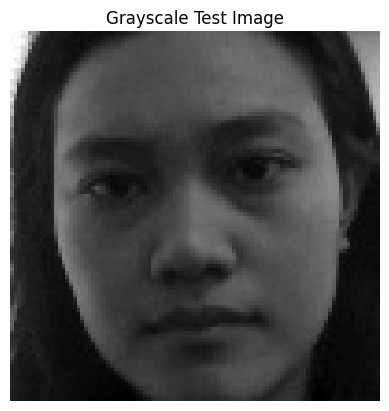

In [ ]:
test_image_path = '/content/drive/My Drive/TugasAkhir/datasetwajah/test1.jpg'
test_image = cv2.imread(test_image_path)
gray_test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
normalized_test_image = cv2.resize(gray_test_image, (100, 100)).flatten() / 255.0
subtracted_test_image = normalized_test_image - mean_image
reduced_test_image = np.dot(eigenvectors[:, :num_components].T, subtracted_test_image)

# Display the grayscale test image
plt.imshow(gray_test_image, cmap='gray')
plt.title('Grayscale Test Image')
plt.axis('off')
plt.show()

In [ ]:
distances = np.linalg.norm(X_train - reduced_test_image, axis=1)

min_distance_index = np.argmin(distances)

prediction = y_train[min_distance_index]

print("Prediction:", prediction)

Prediction: Anggun
